# Imports

In [1]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration's

In [2]:
# =====================
# CONFIGURATION
# =====================
config = {
    "model": "learnable_freq",   # Options: mobilenetv2, convnext, dct, stft, wavelet, learnable_freq
    "epochs": 60,
    "batch_size": 32,
    "lr": 1e-3,
    "early_stopping_patience": 7,
    "dropout": 0.4,
    "num_classes": 5,  # update based on dataset
    "train_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\train",
    "val_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\val",
    "test_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\test",
}
config["save_dir"] = os.path.join("models", config["model"])
os.makedirs(config["save_dir"], exist_ok=True)

config["model_path_auc"] = os.path.join(config["save_dir"], "best_auc.pth")
config["model_path_loss"] = os.path.join(config["save_dir"], "best_loss.pth")
print(f"Models will be saved in: {config['model_path_auc']}")
print(f"Models will be saved in: {config['model_path_loss']}")

Models will be saved in: models\learnable_freq\best_auc.pth
Models will be saved in: models\learnable_freq\best_loss.pth


# Transformation and DataLoader

In [3]:
# =====================
# DATA PIPELINE
# =====================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(config["train_dir"], transform=transform)
val_data = datasets.ImageFolder(config["val_dir"], transform=transform)
test_data = datasets.ImageFolder(config["test_dir"], transform=transform)

train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_data, batch_size=config["batch_size"], shuffle=False)
test_loader = DataLoader(test_data, batch_size=config["batch_size"], shuffle=False)

# =====================
# DEVICE
# =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}" + (f" - {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else ""))

Using device: cuda - NVIDIA GeForce RTX 3050 Laptop GPU


# Model Builder

In [4]:
# =====================
# MODEL BUILDER
# =====================
class ClassifierHead(nn.Module):
    def __init__(self, in_features, num_classes, dropout=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

def build_model(config):
    if config["model"] == "mobilenetv2":
        base = models.mobilenet_v2(weights="IMAGENET1K_V1")
        in_features = base.classifier[1].in_features
        base.classifier = ClassifierHead(in_features, config["num_classes"], config["dropout"])
        return base

    elif config["model"] == "convnext":
        base = models.convnext_tiny(weights="IMAGENET1K_V1")
        in_features = base.classifier[2].in_features
        base.classifier[2] = nn.Linear(in_features, config["num_classes"])
        return base

    elif config["model"] == "dct":
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(224*224*3, 512),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(512, config["num_classes"])
        )

    elif config["model"] == "stft":
        return nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(16, config["num_classes"])
        )

    elif config["model"] == "wavelet":
        return nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, config["num_classes"])
        )

    elif config["model"] == "learnable_freq":
        return nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, config["num_classes"])
        )

    else:
        raise ValueError(f"Unknown model type: {config['model']}")

model = build_model(config).to(device)

# =====================
# TRAINING SETUP
# =====================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["lr"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

# Helper Function's

In [5]:
# =====================
# HELPER FUNCTIONS
# =====================
def compute_metrics(y_true, y_pred, y_prob, average="macro"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class="ovr")
    except:
        auc = 0.0
    return acc, prec, rec, f1, auc

# Training and Validation

In [6]:
best_val_loss = np.inf
best_val_auc = -np.inf
patience_counter = 0

# For tracking
history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": [],
    "train_prec": [], "val_prec": [],
    "train_rec": [], "val_rec": [],
    "train_f1": [], "val_f1": [],
    "train_auc": [], "val_auc": []
}

# Adding SEED 
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# =====================
# TRAINING LOOP
# =====================
for epoch in range(config["epochs"]):
    # -------- TRAIN --------
    model.train()
    train_loss, train_preds, train_labels, train_probs = 0, [], [], []
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        probs = torch.softmax(preds, dim=1)
        train_preds.extend(torch.argmax(preds, 1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        train_probs.extend(probs.cpu().detach().numpy())

    train_loss /= len(train_loader)
    train_acc, train_prec, train_rec, train_f1, train_auc = compute_metrics(
        train_labels, train_preds, train_probs
    )

    # -------- VALIDATION --------
    model.eval()
    val_loss, val_preds, val_labels, val_probs = 0, [], [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Val]"):
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            val_loss += loss.item()
            probs = torch.softmax(preds, dim=1)
            val_preds.extend(torch.argmax(preds, 1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc, val_prec, val_rec, val_f1, val_auc = compute_metrics(
        val_labels, val_preds, val_probs
    )

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_prec"].append(train_prec)
    history["val_prec"].append(val_prec)
    history["train_rec"].append(train_rec)
    history["val_rec"].append(val_rec)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)
    history["train_auc"].append(train_auc)
    history["val_auc"].append(val_auc)

    # Print results like your screenshot
    print(f"\nEpoch {epoch+1}:")
    print(f" Train -> Loss={train_loss:.4f}, Acc={train_acc:.4f}, Prec={train_prec:.4f}, "
          f"Rec={train_rec:.4f}, F1={train_f1:.4f}, AUC={train_auc:.4f}")
    print(f" Val   -> Loss={val_loss:.4f}, Acc={val_acc:.4f}, Prec={val_prec:.4f}, "
          f"Rec={val_rec:.4f}, F1={val_f1:.4f}, AUC={val_auc:.4f}")

    # Save best model based on AUC
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save(model.state_dict(), config["model_path_auc"])
        print(f"Best model (AUC) saved with AUC = {best_val_auc:.4f}")
    else:
        print(f"Validation AUC {val_auc:.4f} did not improve from {best_val_auc:.4f}")

    # Save best model based on Loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), config["model_path_loss"])
        print(f"Best model (Loss) saved with Loss = {best_val_loss:.4f}")
    else:
        print(f"Validation Loss {val_loss:.4f} did not reduced from {best_val_loss:.4f}")

    # Early stopping (based on AUC)
    if val_auc <= best_val_auc:
        patience_counter += 1
        if patience_counter >= config["early_stopping_patience"]:
            print("Early stopping triggered!")
            break


Epoch 1/60 [Val]: 100%|██████████| 84/84 [00:23<00:00,  3.58it/s]



Epoch 1:
 Train -> Loss=1.2118, Acc=0.6048, Prec=0.1441, Rec=0.1996, F1=0.1573, AUC=0.5245
 Val   -> Loss=1.1793, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5441
Best model (AUC) saved with AUC = 0.5441
Best model (Loss) saved with Loss = 1.1793


Epoch 2/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.83it/s]



Epoch 2:
 Train -> Loss=1.1828, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5389
 Val   -> Loss=1.1760, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5663
Best model (AUC) saved with AUC = 0.5663
Best model (Loss) saved with Loss = 1.1760


Epoch 3/60 [Val]: 100%|██████████| 84/84 [00:22<00:00,  3.80it/s]



Epoch 3:
 Train -> Loss=1.1791, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5525
 Val   -> Loss=1.1699, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5800
Best model (AUC) saved with AUC = 0.5800
Best model (Loss) saved with Loss = 1.1699


Epoch 4/60 [Val]: 100%|██████████| 84/84 [00:22<00:00,  3.72it/s]



Epoch 4:
 Train -> Loss=1.1746, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5622
 Val   -> Loss=1.1627, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5873
Best model (AUC) saved with AUC = 0.5873
Best model (Loss) saved with Loss = 1.1627


Epoch 5/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.38it/s]



Epoch 5:
 Train -> Loss=1.1700, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5723
 Val   -> Loss=1.1618, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5937
Best model (AUC) saved with AUC = 0.5937
Best model (Loss) saved with Loss = 1.1618


Epoch 6/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.46it/s]



Epoch 6:
 Train -> Loss=1.1664, Acc=0.6149, Prec=0.3230, Rec=0.2002, F1=0.1526, AUC=0.5814
 Val   -> Loss=1.1547, Acc=0.6157, Prec=0.2232, Rec=0.2007, F1=0.1539, AUC=0.6032
Best model (AUC) saved with AUC = 0.6032
Best model (Loss) saved with Loss = 1.1547


Epoch 7/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.19it/s]



Epoch 7:
 Train -> Loss=1.1605, Acc=0.6152, Prec=0.2164, Rec=0.2010, F1=0.1545, AUC=0.5929
 Val   -> Loss=1.1552, Acc=0.6168, Prec=0.1963, Rec=0.2029, F1=0.1584, AUC=0.6159
Best model (AUC) saved with AUC = 0.6159
Validation Loss 1.1552 did not reduced from 1.1547


Epoch 8/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.25it/s]



Epoch 8:
 Train -> Loss=1.1549, Acc=0.6156, Prec=0.2137, Rec=0.2027, F1=0.1582, AUC=0.6022
 Val   -> Loss=1.1414, Acc=0.6172, Prec=0.1944, Rec=0.2043, F1=0.1611, AUC=0.6279
Best model (AUC) saved with AUC = 0.6279
Best model (Loss) saved with Loss = 1.1414


Epoch 9/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.26it/s]



Epoch 9:
 Train -> Loss=1.1489, Acc=0.6166, Prec=0.2009, Rec=0.2050, F1=0.1627, AUC=0.6157
 Val   -> Loss=1.1363, Acc=0.6194, Prec=0.2132, Rec=0.2111, F1=0.1738, AUC=0.6336
Best model (AUC) saved with AUC = 0.6336
Best model (Loss) saved with Loss = 1.1363


Epoch 10/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.69it/s]



Epoch 10:
 Train -> Loss=1.1453, Acc=0.6167, Prec=0.1882, Rec=0.2062, F1=0.1651, AUC=0.6254
 Val   -> Loss=1.1303, Acc=0.6183, Prec=0.2156, Rec=0.2077, F1=0.1677, AUC=0.6475
Best model (AUC) saved with AUC = 0.6475
Best model (Loss) saved with Loss = 1.1303


Epoch 11/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.76it/s]



Epoch 11:
 Train -> Loss=1.1400, Acc=0.6172, Prec=0.1917, Rec=0.2082, F1=0.1688, AUC=0.6344
 Val   -> Loss=1.1261, Acc=0.6205, Prec=0.2117, Rec=0.2139, F1=0.1784, AUC=0.6520
Best model (AUC) saved with AUC = 0.6520
Best model (Loss) saved with Loss = 1.1261


Epoch 12/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.05it/s]



Epoch 12:
 Train -> Loss=1.1360, Acc=0.6177, Prec=0.1911, Rec=0.2098, F1=0.1715, AUC=0.6424
 Val   -> Loss=1.1254, Acc=0.6202, Prec=0.2189, Rec=0.2119, F1=0.1752, AUC=0.6581
Best model (AUC) saved with AUC = 0.6581
Best model (Loss) saved with Loss = 1.1254


Epoch 13/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.81it/s]



Epoch 13:
 Train -> Loss=1.1330, Acc=0.6187, Prec=0.1912, Rec=0.2113, F1=0.1738, AUC=0.6463
 Val   -> Loss=1.1177, Acc=0.6213, Prec=0.2178, Rec=0.2141, F1=0.1788, AUC=0.6675
Best model (AUC) saved with AUC = 0.6675
Best model (Loss) saved with Loss = 1.1177


Epoch 14/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.46it/s]



Epoch 14:
 Train -> Loss=1.1279, Acc=0.6182, Prec=0.1875, Rec=0.2117, F1=0.1746, AUC=0.6550
 Val   -> Loss=1.1143, Acc=0.6231, Prec=0.2217, Rec=0.2190, F1=0.1865, AUC=0.6731
Best model (AUC) saved with AUC = 0.6731
Best model (Loss) saved with Loss = 1.1143


Epoch 15/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.47it/s]



Epoch 15:
 Train -> Loss=1.1237, Acc=0.6192, Prec=0.1907, Rec=0.2137, F1=0.1777, AUC=0.6611
 Val   -> Loss=1.1100, Acc=0.6235, Prec=0.2938, Rec=0.2204, F1=0.1897, AUC=0.6781
Best model (AUC) saved with AUC = 0.6781
Best model (Loss) saved with Loss = 1.1100


Epoch 16/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.77it/s]



Epoch 16:
 Train -> Loss=1.1207, Acc=0.6192, Prec=0.2229, Rec=0.2148, F1=0.1795, AUC=0.6660
 Val   -> Loss=1.1080, Acc=0.6217, Prec=0.2520, Rec=0.2168, F1=0.1839, AUC=0.6802
Best model (AUC) saved with AUC = 0.6802
Best model (Loss) saved with Loss = 1.1080


Epoch 17/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.44it/s]



Epoch 17:
 Train -> Loss=1.1176, Acc=0.6196, Prec=0.1901, Rec=0.2159, F1=0.1810, AUC=0.6705
 Val   -> Loss=1.1092, Acc=0.6246, Prec=0.2819, Rec=0.2236, F1=0.1934, AUC=0.6837
Best model (AUC) saved with AUC = 0.6837
Validation Loss 1.1092 did not reduced from 1.1080


Epoch 18/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.54it/s]



Epoch 18:
 Train -> Loss=1.1127, Acc=0.6202, Prec=0.2323, Rec=0.2165, F1=0.1821, AUC=0.6734
 Val   -> Loss=1.0989, Acc=0.6261, Prec=0.2168, Rec=0.2266, F1=0.1970, AUC=0.6882
Best model (AUC) saved with AUC = 0.6882
Best model (Loss) saved with Loss = 1.0989


Epoch 19/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.25it/s]



Epoch 19:
 Train -> Loss=1.1111, Acc=0.6203, Prec=0.2397, Rec=0.2173, F1=0.1832, AUC=0.6782
 Val   -> Loss=1.0948, Acc=0.6265, Prec=0.2522, Rec=0.2281, F1=0.1996, AUC=0.6913
Best model (AUC) saved with AUC = 0.6913
Best model (Loss) saved with Loss = 1.0948


Epoch 20/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.68it/s]



Epoch 20:
 Train -> Loss=1.1067, Acc=0.6205, Prec=0.2123, Rec=0.2179, F1=0.1840, AUC=0.6808
 Val   -> Loss=1.0944, Acc=0.6283, Prec=0.2127, Rec=0.2341, F1=0.2056, AUC=0.6936
Best model (AUC) saved with AUC = 0.6936
Best model (Loss) saved with Loss = 1.0944


Epoch 21/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.73it/s]



Epoch 21:
 Train -> Loss=1.1031, Acc=0.6214, Prec=0.3111, Rec=0.2195, F1=0.1864, AUC=0.6851
 Val   -> Loss=1.0904, Acc=0.6250, Prec=0.2661, Rec=0.2259, F1=0.1974, AUC=0.6948
Best model (AUC) saved with AUC = 0.6948
Best model (Loss) saved with Loss = 1.0904


Epoch 22/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.11it/s]



Epoch 22:
 Train -> Loss=1.1023, Acc=0.6215, Prec=0.2905, Rec=0.2213, F1=0.1895, AUC=0.6839
 Val   -> Loss=1.0888, Acc=0.6261, Prec=0.3804, Rec=0.2316, F1=0.2086, AUC=0.6978
Best model (AUC) saved with AUC = 0.6978
Best model (Loss) saved with Loss = 1.0888


Epoch 23/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.68it/s]



Epoch 23:
 Train -> Loss=1.0991, Acc=0.6208, Prec=0.3045, Rec=0.2204, F1=0.1876, AUC=0.6896
 Val   -> Loss=1.0865, Acc=0.6295, Prec=0.2665, Rec=0.2352, F1=0.2085, AUC=0.7000
Best model (AUC) saved with AUC = 0.7000
Best model (Loss) saved with Loss = 1.0865


Epoch 24/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.55it/s]



Epoch 24:
 Train -> Loss=1.0965, Acc=0.6220, Prec=0.2125, Rec=0.2206, F1=0.1877, AUC=0.6906
 Val   -> Loss=1.0815, Acc=0.6280, Prec=0.3252, Rec=0.2338, F1=0.2111, AUC=0.7010
Best model (AUC) saved with AUC = 0.7010
Best model (Loss) saved with Loss = 1.0815


Epoch 25/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.63it/s]



Epoch 25:
 Train -> Loss=1.0937, Acc=0.6215, Prec=0.4268, Rec=0.2221, F1=0.1907, AUC=0.6931
 Val   -> Loss=1.0800, Acc=0.6291, Prec=0.2701, Rec=0.2351, F1=0.2092, AUC=0.7025
Best model (AUC) saved with AUC = 0.7025
Best model (Loss) saved with Loss = 1.0800


Epoch 26/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.45it/s]



Epoch 26:
 Train -> Loss=1.0911, Acc=0.6220, Prec=0.2263, Rec=0.2228, F1=0.1913, AUC=0.6935
 Val   -> Loss=1.0789, Acc=0.6280, Prec=0.4104, Rec=0.2325, F1=0.2090, AUC=0.7036
Best model (AUC) saved with AUC = 0.7036
Best model (Loss) saved with Loss = 1.0789


Epoch 27/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.66it/s]



Epoch 27:
 Train -> Loss=1.0878, Acc=0.6212, Prec=0.2195, Rec=0.2212, F1=0.1891, AUC=0.6970
 Val   -> Loss=1.0749, Acc=0.6287, Prec=0.2696, Rec=0.2356, F1=0.2098, AUC=0.7056
Best model (AUC) saved with AUC = 0.7056
Best model (Loss) saved with Loss = 1.0749


Epoch 28/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.73it/s]



Epoch 28:
 Train -> Loss=1.0853, Acc=0.6227, Prec=0.2321, Rec=0.2242, F1=0.1936, AUC=0.6978
 Val   -> Loss=1.0772, Acc=0.6306, Prec=0.2897, Rec=0.2418, F1=0.2181, AUC=0.7076
Best model (AUC) saved with AUC = 0.7076
Validation Loss 1.0772 did not reduced from 1.0749


Epoch 29/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.46it/s]



Epoch 29:
 Train -> Loss=1.0852, Acc=0.6219, Prec=0.3474, Rec=0.2234, F1=0.1920, AUC=0.6981
 Val   -> Loss=1.0735, Acc=0.6295, Prec=0.3408, Rec=0.2364, F1=0.2132, AUC=0.7073
Validation AUC 0.7073 did not improve from 0.7076
Best model (Loss) saved with Loss = 1.0735


Epoch 30/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.23it/s]



Epoch 30:
 Train -> Loss=1.0829, Acc=0.6228, Prec=0.2370, Rec=0.2241, F1=0.1932, AUC=0.6967
 Val   -> Loss=1.0685, Acc=0.6295, Prec=0.2921, Rec=0.2372, F1=0.2131, AUC=0.7092
Best model (AUC) saved with AUC = 0.7092
Best model (Loss) saved with Loss = 1.0685


Epoch 31/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.41it/s]



Epoch 31:
 Train -> Loss=1.0813, Acc=0.6231, Prec=0.2909, Rec=0.2266, F1=0.1975, AUC=0.7012
 Val   -> Loss=1.0675, Acc=0.6280, Prec=0.3295, Rec=0.2336, F1=0.2092, AUC=0.7096
Best model (AUC) saved with AUC = 0.7096
Best model (Loss) saved with Loss = 1.0675


Epoch 32/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.46it/s]



Epoch 32:
 Train -> Loss=1.0776, Acc=0.6237, Prec=0.2881, Rec=0.2260, F1=0.1964, AUC=0.7018
 Val   -> Loss=1.0660, Acc=0.6295, Prec=0.3240, Rec=0.2377, F1=0.2143, AUC=0.7113
Best model (AUC) saved with AUC = 0.7113
Best model (Loss) saved with Loss = 1.0660


Epoch 33/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.69it/s]



Epoch 33:
 Train -> Loss=1.0767, Acc=0.6237, Prec=0.3169, Rec=0.2276, F1=0.1987, AUC=0.7041
 Val   -> Loss=1.0680, Acc=0.6257, Prec=0.3299, Rec=0.2287, F1=0.2033, AUC=0.7103
Validation AUC 0.7103 did not improve from 0.7113
Validation Loss 1.0680 did not reduced from 1.0660


Epoch 34/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.50it/s]



Epoch 34:
 Train -> Loss=1.0759, Acc=0.6224, Prec=0.2737, Rec=0.2256, F1=0.1962, AUC=0.7035
 Val   -> Loss=1.0659, Acc=0.6283, Prec=0.2740, Rec=0.2338, F1=0.2092, AUC=0.7124
Best model (AUC) saved with AUC = 0.7124
Best model (Loss) saved with Loss = 1.0659


Epoch 35/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.48it/s]



Epoch 35:
 Train -> Loss=1.0752, Acc=0.6235, Prec=0.2859, Rec=0.2270, F1=0.1988, AUC=0.7057
 Val   -> Loss=1.0705, Acc=0.6313, Prec=0.2870, Rec=0.2457, F1=0.2218, AUC=0.7148
Best model (AUC) saved with AUC = 0.7148
Validation Loss 1.0705 did not reduced from 1.0659


Epoch 36/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.61it/s]



Epoch 36:
 Train -> Loss=1.0714, Acc=0.6248, Prec=0.3079, Rec=0.2298, F1=0.2017, AUC=0.7073
 Val   -> Loss=1.0602, Acc=0.6280, Prec=0.2747, Rec=0.2350, F1=0.2110, AUC=0.7144
Validation AUC 0.7144 did not improve from 0.7148
Best model (Loss) saved with Loss = 1.0602


Epoch 37/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.22it/s]



Epoch 37:
 Train -> Loss=1.0705, Acc=0.6249, Prec=0.3394, Rec=0.2318, F1=0.2062, AUC=0.7082
 Val   -> Loss=1.0592, Acc=0.6328, Prec=0.2901, Rec=0.2468, F1=0.2232, AUC=0.7165
Best model (AUC) saved with AUC = 0.7165
Best model (Loss) saved with Loss = 1.0592


Epoch 38/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.47it/s]



Epoch 38:
 Train -> Loss=1.0707, Acc=0.6250, Prec=0.3105, Rec=0.2311, F1=0.2038, AUC=0.7076
 Val   -> Loss=1.0646, Acc=0.6321, Prec=0.3225, Rec=0.2464, F1=0.2241, AUC=0.7161
Validation AUC 0.7161 did not improve from 0.7165
Validation Loss 1.0646 did not reduced from 1.0592


Epoch 39/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.60it/s]



Epoch 39:
 Train -> Loss=1.0697, Acc=0.6261, Prec=0.3348, Rec=0.2339, F1=0.2085, AUC=0.7092
 Val   -> Loss=1.0587, Acc=0.6295, Prec=0.3400, Rec=0.2454, F1=0.2298, AUC=0.7192
Best model (AUC) saved with AUC = 0.7192
Best model (Loss) saved with Loss = 1.0587


Epoch 40/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.69it/s]



Epoch 40:
 Train -> Loss=1.0672, Acc=0.6247, Prec=0.2824, Rec=0.2314, F1=0.2050, AUC=0.7096
 Val   -> Loss=1.0568, Acc=0.6298, Prec=0.3533, Rec=0.2365, F1=0.2138, AUC=0.7168
Validation AUC 0.7168 did not improve from 0.7192
Best model (Loss) saved with Loss = 1.0568


Epoch 41/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.18it/s]



Epoch 41:
 Train -> Loss=1.0680, Acc=0.6255, Prec=0.3096, Rec=0.2327, F1=0.2068, AUC=0.7104
 Val   -> Loss=1.0538, Acc=0.6317, Prec=0.2961, Rec=0.2416, F1=0.2186, AUC=0.7183
Validation AUC 0.7183 did not improve from 0.7192
Best model (Loss) saved with Loss = 1.0538


Epoch 42/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.36it/s]



Epoch 42:
 Train -> Loss=1.0663, Acc=0.6260, Prec=0.2899, Rec=0.2329, F1=0.2060, AUC=0.7117
 Val   -> Loss=1.0587, Acc=0.6343, Prec=0.3602, Rec=0.2490, F1=0.2265, AUC=0.7192
Validation AUC 0.7192 did not improve from 0.7192
Validation Loss 1.0587 did not reduced from 1.0538


Epoch 43/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.44it/s]



Epoch 43:
 Train -> Loss=1.0640, Acc=0.6266, Prec=0.3369, Rec=0.2351, F1=0.2096, AUC=0.7124
 Val   -> Loss=1.0544, Acc=0.6324, Prec=0.3759, Rec=0.2467, F1=0.2246, AUC=0.7211
Best model (AUC) saved with AUC = 0.7211
Validation Loss 1.0544 did not reduced from 1.0538


Epoch 44/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.56it/s]



Epoch 44:
 Train -> Loss=1.0631, Acc=0.6257, Prec=0.2981, Rec=0.2338, F1=0.2078, AUC=0.7126
 Val   -> Loss=1.0495, Acc=0.6321, Prec=0.2857, Rec=0.2485, F1=0.2306, AUC=0.7223
Best model (AUC) saved with AUC = 0.7223
Best model (Loss) saved with Loss = 1.0495


Epoch 45/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.62it/s]



Epoch 45:
 Train -> Loss=1.0628, Acc=0.6267, Prec=0.3272, Rec=0.2363, F1=0.2120, AUC=0.7139
 Val   -> Loss=1.0500, Acc=0.6328, Prec=0.3497, Rec=0.2461, F1=0.2233, AUC=0.7219
Validation AUC 0.7219 did not improve from 0.7223
Validation Loss 1.0500 did not reduced from 1.0495


Epoch 46/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.18it/s]



Epoch 46:
 Train -> Loss=1.0604, Acc=0.6267, Prec=0.2983, Rec=0.2358, F1=0.2099, AUC=0.7151
 Val   -> Loss=1.0497, Acc=0.6321, Prec=0.3222, Rec=0.2423, F1=0.2205, AUC=0.7219
Validation AUC 0.7219 did not improve from 0.7223
Validation Loss 1.0497 did not reduced from 1.0495


Epoch 47/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.65it/s]



Epoch 47:
 Train -> Loss=1.0603, Acc=0.6265, Prec=0.3207, Rec=0.2372, F1=0.2133, AUC=0.7157
 Val   -> Loss=1.0519, Acc=0.6313, Prec=0.3046, Rec=0.2418, F1=0.2216, AUC=0.7229
Best model (AUC) saved with AUC = 0.7229
Validation Loss 1.0519 did not reduced from 1.0495


Epoch 48/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.16it/s]



Epoch 48:
 Train -> Loss=1.0586, Acc=0.6268, Prec=0.3113, Rec=0.2364, F1=0.2125, AUC=0.7173
 Val   -> Loss=1.0512, Acc=0.6321, Prec=0.3144, Rec=0.2478, F1=0.2258, AUC=0.7239
Best model (AUC) saved with AUC = 0.7239
Validation Loss 1.0512 did not reduced from 1.0495


Epoch 49/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.66it/s]



Epoch 49:
 Train -> Loss=1.0585, Acc=0.6272, Prec=0.3060, Rec=0.2375, F1=0.2134, AUC=0.7163
 Val   -> Loss=1.0483, Acc=0.6324, Prec=0.3378, Rec=0.2448, F1=0.2219, AUC=0.7240
Best model (AUC) saved with AUC = 0.7240
Best model (Loss) saved with Loss = 1.0483


Epoch 50/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.24it/s]



Epoch 50:
 Train -> Loss=1.0591, Acc=0.6259, Prec=0.3032, Rec=0.2364, F1=0.2112, AUC=0.7162
 Val   -> Loss=1.0457, Acc=0.6328, Prec=0.3478, Rec=0.2503, F1=0.2323, AUC=0.7265
Best model (AUC) saved with AUC = 0.7265
Best model (Loss) saved with Loss = 1.0457


Epoch 51/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.25it/s]



Epoch 51:
 Train -> Loss=1.0593, Acc=0.6267, Prec=0.3073, Rec=0.2385, F1=0.2154, AUC=0.7157
 Val   -> Loss=1.0526, Acc=0.6350, Prec=0.4199, Rec=0.2599, F1=0.2368, AUC=0.7267
Best model (AUC) saved with AUC = 0.7267
Validation Loss 1.0526 did not reduced from 1.0457


Epoch 52/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.42it/s]



Epoch 52:
 Train -> Loss=1.0541, Acc=0.6265, Prec=0.2927, Rec=0.2365, F1=0.2107, AUC=0.7214
 Val   -> Loss=1.0573, Acc=0.6291, Prec=0.3006, Rec=0.2439, F1=0.2265, AUC=0.7248
Validation AUC 0.7248 did not improve from 0.7267
Validation Loss 1.0573 did not reduced from 1.0457


Epoch 53/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.59it/s]



Epoch 53:
 Train -> Loss=1.0553, Acc=0.6262, Prec=0.2782, Rec=0.2364, F1=0.2114, AUC=0.7206
 Val   -> Loss=1.0456, Acc=0.6321, Prec=0.2918, Rec=0.2454, F1=0.2220, AUC=0.7256
Validation AUC 0.7256 did not improve from 0.7267
Best model (Loss) saved with Loss = 1.0456


Epoch 54/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.23it/s]



Epoch 54:
 Train -> Loss=1.0533, Acc=0.6274, Prec=0.3275, Rec=0.2371, F1=0.2130, AUC=0.7213
 Val   -> Loss=1.0429, Acc=0.6313, Prec=0.2827, Rec=0.2438, F1=0.2246, AUC=0.7278
Best model (AUC) saved with AUC = 0.7278
Best model (Loss) saved with Loss = 1.0429


Epoch 55/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.24it/s]



Epoch 55:
 Train -> Loss=1.0541, Acc=0.6269, Prec=0.3116, Rec=0.2382, F1=0.2145, AUC=0.7191
 Val   -> Loss=1.0436, Acc=0.6313, Prec=0.3099, Rec=0.2500, F1=0.2345, AUC=0.7294
Best model (AUC) saved with AUC = 0.7294
Validation Loss 1.0436 did not reduced from 1.0429


Epoch 56/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.15it/s]



Epoch 56:
 Train -> Loss=1.0519, Acc=0.6271, Prec=0.3152, Rec=0.2400, F1=0.2178, AUC=0.7227
 Val   -> Loss=1.0497, Acc=0.6302, Prec=0.3738, Rec=0.2394, F1=0.2190, AUC=0.7273
Validation AUC 0.7273 did not improve from 0.7294
Validation Loss 1.0497 did not reduced from 1.0429


Epoch 57/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.82it/s]



Epoch 57:
 Train -> Loss=1.0513, Acc=0.6280, Prec=0.3093, Rec=0.2391, F1=0.2150, AUC=0.7240
 Val   -> Loss=1.0452, Acc=0.6343, Prec=0.3837, Rec=0.2599, F1=0.2413, AUC=0.7314
Best model (AUC) saved with AUC = 0.7314
Validation Loss 1.0452 did not reduced from 1.0429


Epoch 58/60 [Val]: 100%|██████████| 84/84 [00:23<00:00,  3.61it/s]



Epoch 58:
 Train -> Loss=1.0522, Acc=0.6282, Prec=0.3255, Rec=0.2409, F1=0.2190, AUC=0.7221
 Val   -> Loss=1.0414, Acc=0.6310, Prec=0.3299, Rec=0.2398, F1=0.2193, AUC=0.7293
Validation AUC 0.7293 did not improve from 0.7314
Best model (Loss) saved with Loss = 1.0414


Epoch 59/60 [Val]: 100%|██████████| 84/84 [00:22<00:00,  3.68it/s]



Epoch 59:
 Train -> Loss=1.0501, Acc=0.6286, Prec=0.3126, Rec=0.2407, F1=0.2175, AUC=0.7232
 Val   -> Loss=1.0549, Acc=0.6295, Prec=0.4233, Rec=0.2389, F1=0.2199, AUC=0.7264
Validation AUC 0.7264 did not improve from 0.7314
Validation Loss 1.0549 did not reduced from 1.0414


Epoch 60/60 [Val]: 100%|██████████| 84/84 [00:23<00:00,  3.58it/s]


Epoch 60:
 Train -> Loss=1.0496, Acc=0.6290, Prec=0.3322, Rec=0.2415, F1=0.2188, AUC=0.7249
 Val   -> Loss=1.0412, Acc=0.6358, Prec=0.3562, Rec=0.2534, F1=0.2364, AUC=0.7308
Validation AUC 0.7308 did not improve from 0.7314
Best model (Loss) saved with Loss = 1.0412


# Testing and Plotting


=== Test Results ===
 Loss=1.0589, Acc=0.6261, Prec=0.2732, Rec=0.2453, F1=0.2231, AUC=0.7275, Spec=0.8196


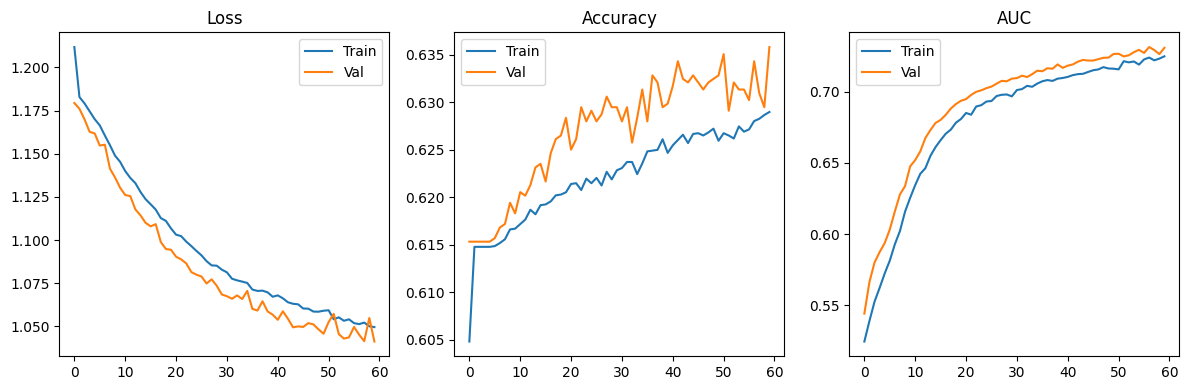

In [7]:
# =====================
# TESTING
# =====================
model.load_state_dict(torch.load(config["model_path_auc"]))
model.eval()
test_loss, test_preds, test_labels, test_probs = 0, [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        test_loss += loss.item()
        probs = torch.softmax(preds, dim=1)
        test_preds.extend(torch.argmax(preds, 1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_loss /= len(test_loader)
test_acc, test_prec, test_rec, test_f1, test_auc = compute_metrics(test_labels, test_preds, test_probs)

# Specificity (macro-averaged)
cm = confusion_matrix(test_labels, test_preds)
tn = cm.sum() - (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
fp = cm.sum(axis=0) - np.diag(cm)
specificity = np.mean(tn / (tn + fp + 1e-8))

print("\n=== Test Results ===")
print(f" Loss={test_loss:.4f}, Acc={test_acc:.4f}, Prec={test_prec:.4f}, "
      f"Rec={test_rec:.4f}, F1={test_f1:.4f}, AUC={test_auc:.4f}, Spec={specificity:.4f}")

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.close()

# =====================
# FINAL SUMMARY PLOT
# =====================
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history["train_auc"], label="Train")
plt.plot(history["val_auc"], label="Val")
plt.title("AUC")
plt.legend()

plt.tight_layout()
plt.savefig("summary.png")
plt.show()